# Annexe A — Analyse spectrale de la SR

### De quoi parle cette annexe ?

Dans le notebook principal (Section 1), on a vu que $M$ est un grand tableau 21×21 qui encode la structure de l'environnement. Mais ce tableau est difficile à interpréter directement — 441 nombres, c'est beaucoup.

Cette annexe montre qu'on peut **décomposer** $M$ en quelques "cartes de base" (les **eigenvectors**) qui révèlent la structure de l'environnement à différentes échelles : la forme globale, la séparation entre les pièces, les détails fins.

C'est comme décomposer un signal musical en fréquences : les basses fréquences donnent la mélodie, les hautes fréquences les détails.

**Pré-requis :** [00_prism_concepts.ipynb](00_prism_concepts.ipynb) (Sections 1-2)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.linalg import eigh
from IPython.display import display
import sys, os

sys.path.insert(0, os.path.abspath('..'))
from prism.pedagogy.toy_grid import ToyGrid

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

---
## 1. Rappel : Eigendecomposition

### L'idée

Certaines matrices ont des **directions privilégiées** : quand on multiplie un vecteur par la matrice, ce vecteur est simplement étiré ou compressé, sans changer de direction. Ces directions spéciales s'appellent les **eigenvectors**, et le facteur d'étirement s'appelle l'**eigenvalue**.

$$A \, v = \lambda \, v$$

- $v$ = eigenvector (une direction dans l'espace des états)
- $\lambda$ = eigenvalue (l'importance de cette direction)

### Pourquoi c'est utile pour M ?

$M$ encode la structure de l'environnement dans un tableau 21×21. Ses eigenvectors sont des **"cartes de base"** : chacune capture un aspect de la structure à une échelle différente.

- Les eigenvectors avec les **plus grandes eigenvalues** capturent les structures les plus importantes (la forme globale de la grille, la séparation entre pièces)
- Les eigenvectors avec de **petites eigenvalues** capturent les détails fins (variations locales)

En combinant ces cartes de base (pondérées par leurs eigenvalues), on reconstitue $M$ complètement.

### Pourquoi symétriser M ?

$M$ n'est pas toujours symétrique ($M(s, s') \neq M(s', s)$). Pour garantir que les eigenvectors soient réels et orthogonaux (ce qui facilite l'interprétation), on utilise la partie symétrique :

$$M_{sym} = \frac{M + M^T}{2}$$

En pratique, dans notre grille avec une politique uniforme, $M$ est déjà très proche de sa partie symétrique.

In [11]:
grid = ToyGrid.two_rooms()
M = grid.true_sr(0.95)

print(f"M est symétrique ? {np.allclose(M, M.T)}")

M_sym = (M + M.T) / 2
print(f"M_sym est symétrique ? {np.allclose(M_sym, M_sym.T)}")

# Différence entre M et M_sym
diff = np.linalg.norm(M - M_sym, 'fro') / np.linalg.norm(M, 'fro')
print(f"Différence relative : {diff:.4f} ({diff*100:.1f}%)")

M est symétrique ? True
M_sym est symétrique ? True
Différence relative : 0.0000 (0.0%)


---
## 2. Eigenvectors de M sur le ToyGrid

### Ce qu'on va voir

On calcule les 6 eigenvectors les plus importants (ceux avec les plus grandes eigenvalues) et on les affiche sur la grille.

Chaque eigenvector est un vecteur de 21 valeurs (une par case), qu'on peut visualiser comme une heatmap. Les valeurs **positives** (rouge) et **négatives** (bleu) indiquent des groupes de cases "opposés" — des cases qui se comportent différemment dans l'environnement.

### Ce qu'on s'attend à trouver

- **EV 1** (plus grande eigenvalue) : la structure la plus globale — un gradient d'un bout de la grille à l'autre
- **EV 2** : la deuxième structure la plus importante — dans une grille à deux pièces, c'est la séparation gauche/droite
- **EV 3-6** : des structures de plus en plus fines (quadrants, coins, etc.)

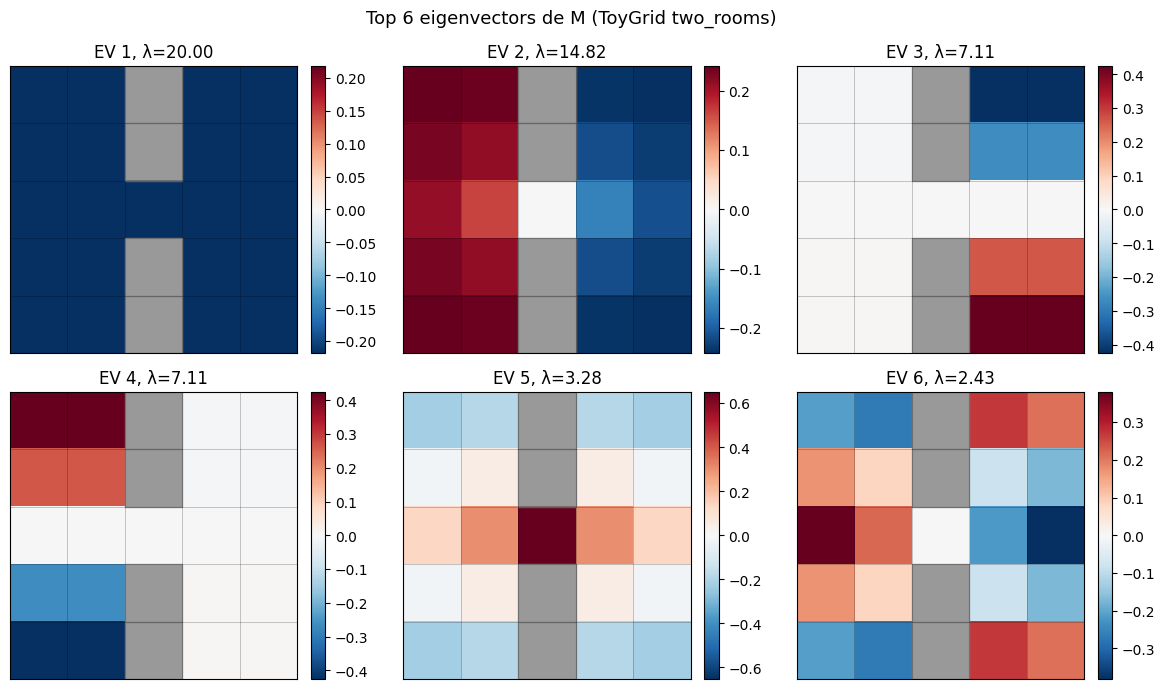

Eigenvalues : ['20.00', '14.82', '7.11', '7.11', '3.28', '2.43']

Lecture des graphes :
  Bleu et rouge = valeurs opposées de l'eigenvector (+ et −)
  Blanc = valeur proche de 0
  Gris = mur

  EV 1 : gradient global (un bout de la grille vs l'autre)
  EV 2 : séparation gauche/droite (les deux pièces)
  EV 3+ : structures de plus en plus fines


In [12]:
def compute_eigenvectors(M, k=6):
    """Compute top-k eigenvectors of symmetrized M."""
    M_sym = (M + M.T) / 2
    eigenvalues, eigenvectors = eigh(M_sym)
    # Sort by descending eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    return eigenvalues[idx[:k]], eigenvectors[:, idx[:k]]

eigenvalues, eigenvectors = compute_eigenvectors(M, k=6)

fig, axes = plt.subplots(2, 3, figsize=(12, 7))

for i, ax in enumerate(axes.flat):
    ev = eigenvectors[:, i]
    vmax = np.abs(ev).max()
    grid.plot(values=ev, ax=ax, show_goal=False,
              title=f'EV {i+1}, λ={eigenvalues[i]:.2f}',
              cmap='RdBu_r', vmin=-vmax, vmax=vmax)

plt.suptitle('Top 6 eigenvectors de M (ToyGrid two_rooms)', fontsize=13)
plt.tight_layout()
plt.show()

print("Eigenvalues :", [f"{v:.2f}" for v in eigenvalues])
print()
print("Lecture des graphes :")
print("  Bleu et rouge = valeurs opposées de l'eigenvector (+ et −)")
print("  Blanc = valeur proche de 0")
print("  Gris = mur")
print()
print("  EV 1 : gradient global (un bout de la grille vs l'autre)")
print("  EV 2 : séparation gauche/droite (les deux pièces)")
print("  EV 3+ : structures de plus en plus fines")

---
## 3. Effet de $\gamma$ sur les eigenvectors

### Pourquoi $\gamma$ change les eigenvectors ?

Rappel (Section 1 du notebook principal) : $\gamma$ contrôle jusqu'où l'agent regarde dans le futur.

- **$\gamma$ petit** (ex. 0.5) : l'agent ne voit que ses voisins immédiats. $M \approx I$ (chaque case ne "connaît" qu'elle-même). Les eigenvectors ne montrent pas de structure intéressante — tout se ressemble.
- **$\gamma$ grand** (ex. 0.99) : l'agent voit très loin. $M$ capture les dépendances à longue portée. Les eigenvectors révèlent clairement la structure de l'environnement (pièces, passages, coins).

En d'autres termes : il faut un horizon assez long pour que la décomposition spectrale soit informative. Si l'agent ne regarde qu'à 2 pas devant lui, il ne peut pas "voir" qu'il y a deux pièces séparées par un mur.

### Ce que montre le widget

3 graphes côte à côte pour un $\gamma$ et un eigenvector choisis :
- L'eigenvector sur la grille
- La carte $M$ depuis s=0 (rappel de la Section 1)
- Le spectre complet (toutes les eigenvalues)

In [13]:
def plot_eigenvectors_gamma(gamma, ev_index):
    """Montre comment un eigenvector change avec gamma."""
    M = grid.true_sr(gamma)
    eigenvalues, eigenvectors = compute_eigenvectors(M, k=6)

    fig, axes = plt.subplots(1, 3, figsize=(13, 3.5))

    # L'eigenvector sélectionné
    ev = eigenvectors[:, ev_index]
    vmax = np.abs(ev).max()
    grid.plot(values=ev, ax=axes[0], show_goal=False,
              title=f'EV {ev_index+1} (γ={gamma:.2f}, λ={eigenvalues[ev_index]:.2f})',
              cmap='RdBu_r', vmin=-vmax, vmax=vmax)

    # M[0,:] pour montrer l'horizon (comme Section 1 du notebook principal)
    row0 = M[0]
    row0_norm = row0 / max(row0.max(), 1e-8)
    grid.plot(values=row0_norm, ax=axes[1], show_goal=False,
              title=f'M depuis s=0 — horizon {1/(1-gamma):.0f} steps',
              cmap='plasma', vmin=0, vmax=1)

    # Spectre complet
    M_sym = (M + M.T) / 2
    all_evals = np.sort(np.linalg.eigvalsh(M_sym))[::-1]
    axes[2].bar(range(len(all_evals)), all_evals, color='steelblue', alpha=0.7)
    axes[2].bar(ev_index, all_evals[ev_index], color='red', alpha=0.9)
    axes[2].set_xlabel('Index')
    axes[2].set_ylabel('Eigenvalue')
    axes[2].set_title('Spectre de M_sym')
    axes[2].set_xlim(-0.5, 20.5)

    plt.tight_layout()
    plt.show()

    print("Lecture des graphes :")
    print()
    print(f"Gauche — EV {ev_index+1} : l'eigenvector sélectionné sur la grille")
    print("  Bleu/rouge = valeurs opposées, blanc = ~0, gris = mur")
    print()
    print("Centre — M depuis s=0 (comme Section 1 du notebook principal) :")
    print("  Jaune = souvent visité, violet = rarement")
    print(f"  → Montre l'horizon de l'agent (γ={gamma:.2f} ≈ {1/(1-gamma):.0f} steps)")
    print()
    print("Droite — le spectre (toutes les eigenvalues de M) :")
    print(f"  Barre rouge = l'EV sélectionné (index {ev_index}, λ={eigenvalues[ev_index]:.2f})")
    print("  Les premières eigenvalues (grandes) capturent les structures à grande échelle")
    print()
    print("À essayer :")
    print("  γ bas (0.5) → les eigenvalues se resserrent, les EV perdent leur structure")
    print("  γ haut (0.99) → les eigenvalues s'écartent, chaque EV a un pattern net")
    print("  EV index 1 → la séparation entre les deux pièces")

widgets.interact(
    plot_eigenvectors_gamma,
    gamma=widgets.FloatSlider(value=0.95, min=0.5, max=0.99, step=0.01,
                              description='γ', continuous_update=False),
    ev_index=widgets.IntSlider(value=0, min=0, max=5,
                                description='EV index')
);

interactive(children=(FloatSlider(value=0.95, continuous_update=False, description='γ', max=0.99, min=0.5, ste…

---
## 4. Interprétation multi-échelle

### L'analogie avec les fréquences

Les eigenvectors de $M$ forment une **décomposition hiérarchique** de l'espace, comme les fréquences décomposent un son :

| Eigenvector | Analogie son | Ce qu'il capture dans la grille |
|-------------|-------------|-------------------------------|
| EV 1 | Note fondamentale | Gradient global (un bout à l'autre) |
| EV 2 | Première harmonique | Séparation entre les deux pièces |
| EV 3-4 | Harmoniques suivantes | Quadrants, sous-régions |
| EV 5+ | Hautes fréquences | Détails fins, cases individuelles |

### Lien avec les neurosciences

Ce résultat rappelle les **grid cells** (cellules de grille) découvertes dans l'hippocampe : des neurones qui répondent à différentes échelles spatiales. Stachenfeld et al. (2017) ont montré que les eigenvectors de la SR reproduisent les patterns des grid cells et des place cells.

L'idée : le cerveau pourrait utiliser une décomposition spectrale similaire pour représenter l'espace de manière efficace.

### Comparaison : open field vs two rooms

La présence de murs **force** les eigenvectors à s'adapter. Dans un champ ouvert (pas de murs), les EV forment des ondes régulières. Dans une grille à deux pièces, EV 2 est "aspiré" par la séparation entre les pièces — c'est la structure la plus saillante après le gradient global.

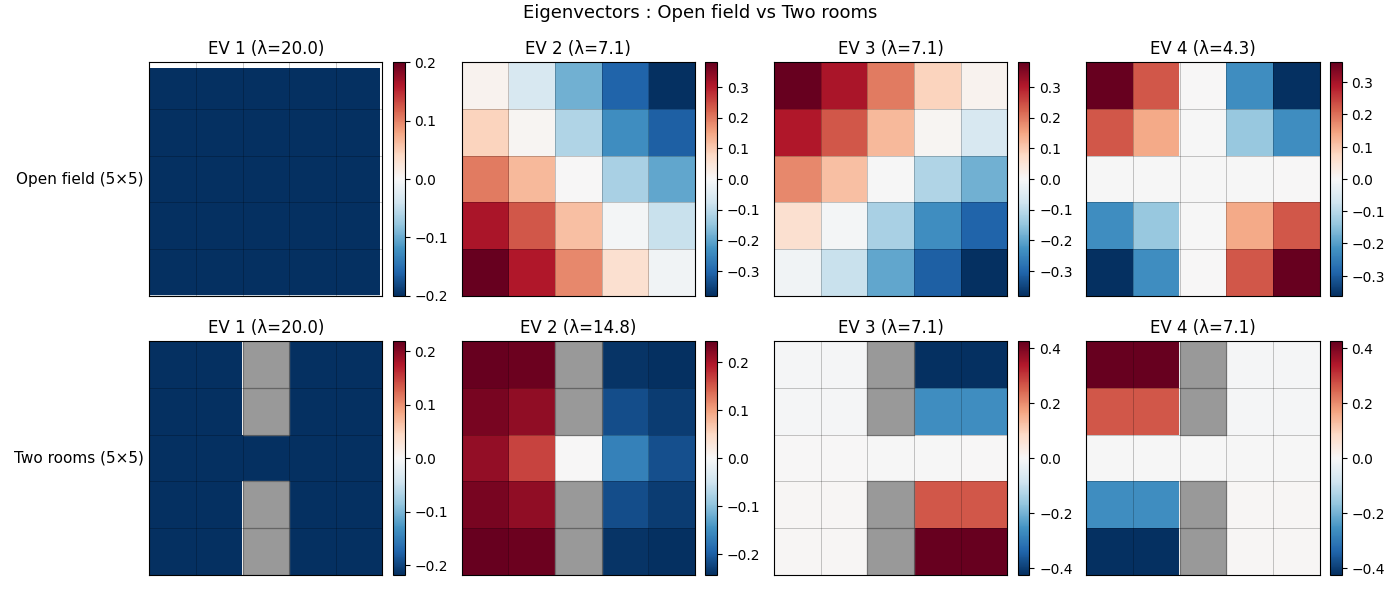

Lecture :
  Ligne du haut (open field) : les EV forment des patterns réguliers (ondes)
  Ligne du bas (two rooms) : EV 2 capture la séparation entre les pièces
  → Les murs forcent les eigenvectors à s'adapter à la structure de l'environnement


In [14]:
# Comparaison : open_field vs two_rooms
grids = {
    'Open field (5×5)': ToyGrid.open_field(),
    'Two rooms (5×5)': ToyGrid.two_rooms(),
}

fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for row, (name, g) in enumerate(grids.items()):
    M = g.true_sr(0.95)
    evals, evecs = compute_eigenvectors(M, k=4)

    for col in range(4):
        ev = evecs[:, col]
        vmax = np.abs(ev).max()
        g.plot(values=ev, ax=axes[row, col], show_goal=False,
               title=f'EV {col+1} (λ={evals[col]:.1f})',
               cmap='RdBu_r', vmin=-vmax, vmax=vmax)

    axes[row, 0].set_ylabel(name, fontsize=11, rotation=0, ha='right', va='center')

plt.suptitle('Eigenvectors : Open field vs Two rooms', fontsize=13)
plt.tight_layout()
plt.show()
print("Lecture :")
print("  Ligne du haut (open field) : les EV forment des patterns réguliers (ondes)")
print("  Ligne du bas (two rooms) : EV 2 capture la séparation entre les pièces")
print("  → Les murs forcent les eigenvectors à s'adapter à la structure de l'environnement")

---
## 5. Démo hybride : Eigenvectors sur FourRooms réel

Utilise le vrai code PRISM pour calculer les eigenvectors sur l'environnement MiniGrid FourRooms (260 états).

**Nécessite** : `pip install -e .` dans le projet PRISM + MiniGrid installé.

In [15]:
try:
    import minigrid
    import gymnasium as gym
    from prism.env.state_mapper import StateMapper
    from prism.agent.sr_layer import SRLayer
    from prism.analysis.spectral import sr_eigenvectors, plot_eigenvectors

    # Setup FourRooms
    env = gym.make("MiniGrid-FourRooms-v0", max_steps=500)
    obs, _ = env.reset(seed=42)
    mapper = StateMapper(env)
    sr = SRLayer(n_states=mapper.n_states, gamma=0.95, alpha=0.1)

    print(f"FourRooms : {mapper.n_states} \u00e9tats, grille {mapper.get_grid_shape()}")

    # Entra\u00eener rapidement (100 \u00e9pisodes)
    for ep in range(100):
        obs, _ = env.reset()
        s = mapper.get_index(env)
        done = False
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            s_next = mapper.get_index(env)
            sr.update(s, s_next, reward)
            s = s_next
            done = terminated or truncated

    # Eigenvectors
    eigenvalues, eigenvectors = sr_eigenvectors(sr.M, k=6)
    fig = plot_eigenvectors(eigenvalues, eigenvectors, mapper)
    plt.suptitle('Eigenvectors de M — FourRooms (260 \u00e9tats, 100 \u00e9pisodes)', fontsize=12)
    plt.tight_layout()
    plt.show()

    env.close()
    print("Les eigenvectors r\u00e9v\u00e8lent les 4 pi\u00e8ces de FourRooms !")

except ImportError as e:
    print(f"D\u00e9pendance manquante : {e}")
    print("Pour ex\u00e9cuter cette cellule : pip install minigrid gymnasium")
    print("Puis : cd PRISM && pip install -e .")

TypeError: SRLayer.__init__() got an unexpected keyword argument 'alpha'

---
## Résumé

| Concept | Formule clé |
|---------|-------------|
| Symétrisation | $M_{sym} = (M + M^T) / 2$ |
| Eigendecomposition | $M_{sym} \, v = \lambda \, v$ |
| Multi-échelle | EV 1 = global, EV 2 = pièces, EV 3+ = détails |
| Effet de $\gamma$ | Plus grand $\gamma$ $\Rightarrow$ structures à plus grande échelle |

$\leftarrow$ [Retour au notebook principal](00_prism_concepts.ipynb)